In [1]:
using Distributions, LinearAlgebra, Plots, Random, LargeMessageCollider
Random.seed!(1234);

In [2]:
# Generate a synthetic data
A = [1 0.1; 0 1]
B = [1 0]
Q = [0.1^3/3 0.1^2/2; 0.1^2/2 0.1]
R = 1

T = 20

x_real = zeros(2,T)
y_real = zeros(T)

x_real[:,1] = rand(MvNormal(zeros(2),diagm(0=>ones(2))))
y_real[1] = rand(Normal((B*x_real[:,1])[1],R))
for t=2:T
    x_real[:,t] = rand(MvNormal(A*x_real[:,t-1],Q))
    y_real[t] = rand(Normal((B*x_real[:,t])[1],R))
end

In [3]:
# Priors
p1 = MvNormal(zeros(2),diagm(0=>ones(2)))
pW = Wishart(2, diagm(0=>ones(2)))
pS = Gamma(1,2)
;

In [6]:
vmp = VMP() # a VMP instance to enable VMP message passing
# Filtering method
function filter(qW, qS, T)
    forward_estimates = Array{MvNormal}(undef, T)
    measure = B\normal(vmp,y_real[1],nothing,qS) # VMP message
    forward_estimates[1] = p1 * measure # Update
    for t=2:T
        predict = transit(vmp,forward_estimates[t-1],A,qW) # Predict message structured VMP
        measure = B\normal(vmp,y_real[t],nothing,qS) # VMP message
        forward_estimates[t] = predict * measure
    end
    return forward_estimates
end

# Smoothing method
function smooth(forward_estimates, qW, T)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(vmp,forward_estimates[t],smooth_estimates[t+1],A,qW)
    end
    return smooth_estimates, joint_dists
end
;

In [7]:
# Inference

qW = pW # initial qW
qS = pS # initial qR

n_its = 25 # number of iterations
FE = zeros(n_its) # store Free energy

# Variational updates
for i=1:n_its
    # Update q(x_{1:T})
    forward_estimates = filter(qW,qS,T)
    smooth_estimates, joint_dists = smooth(forward_estimates, qW, T)
    
    # Update qW
    qW = pW
    for t=1:T-1
        message = transit(vmp,smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,nothing)
        qW *= message
    end
    
    # Update qS
    qS = pS
    for t=1:T
        message = normal(vmp,y_real[t],B*smooth_estimates[t],nothing)
        qS *= message
    end
    
    # Calculate Free Energy
    F = -entropy(qW) -entropy(qS) - entropy(smooth_estimates[1])
    F += cross_entropy(qW,pW) + cross_entropy(qS,pS) + cross_entropy(smooth_estimates[1], p1)
    for t=1:T-1
        F -= normal_conditional_entropy(smooth_estimates[t], smooth_estimates[t+1], joint_dists[t])
        F += transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,qW)
        F += normal(y_real[t],B*smooth_estimates[t],qS)
    end
    F += normal(y_real[T],B*smooth_estimates[T],qS)
    FE[i] = F
end

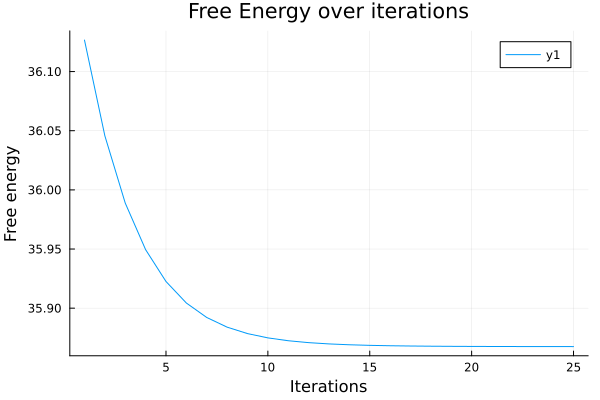

In [8]:
plot(FE, title="Free Energy over iterations", xlabel="Iterations", ylabel="Free energy")

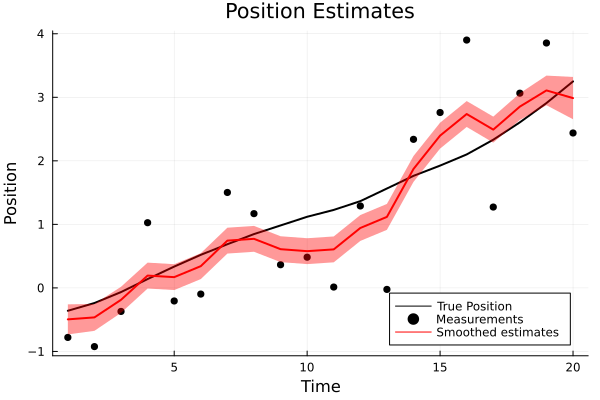

In [9]:
forward_estimates = filter(qW,qS,T)
smooth_estimates, joint_dists = smooth(forward_estimates, qW, T)

y_filter_m, y_filter_v = zeros(T), zeros(T)
y_smooth_m, y_smooth_v = zeros(T), zeros(T)
for t=1:T
    y_smooth_m[t] = mean(smooth_estimates[t])[1]
    y_smooth_v[t] = cov(smooth_estimates[t])[1,1]
end

plot(x_real[1,:], color=:black, lw=2, title="Position Estimates", xaxis="Time", yaxis="Position", label="True Position")
scatter!(collect(1:T), y_real, color=:black, xaxis="Time", yaxis="Position", label="Measurements")
plot!(y_smooth_m, lw=2, color=:red, ribbon=y_smooth_v, fillalpha=0.4, label="Smoothed estimates", legend=:bottomright)